# MNIST dataset feature reductoin and classification

### Aidin Hosseini - 98103115
---

### Contents:
1. Importing libraries
2. Loading data
3. PCA
4. charts
5. Autoencoder
6. LDA
7. Classification

### Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

### Loading the dataset

In [2]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
feature_count = 0

### Visualizing

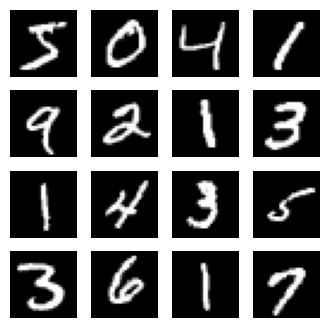

In [3]:
# visuliaze 10 random images from the training set
number_img = 4
fig, ax = plt.subplots(number_img, number_img, figsize=(number_img, number_img))
for i in range(number_img):
    for j in range(number_img):
        ax[i,j].set_axis_off()
        ax[i,j].imshow(x_train[i*number_img+j], cmap='gray')


### changing dataset type
&nbsp; In the cell below shape of the dataset is changed into a 2D array. Also the value of each pixel is scaled in [0,1]. To do this the dataset is divided by 255. 

In [4]:
# 2D array
print(x_train.shape)
print(x_test.shape)
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
# Scaling the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.




(60000, 28, 28)
(10000, 28, 28)


### Implementing PCA
&nbsp; The my_PCA class has 3 methods.<br>
&nbsp; &nbsp; 1. fit: This method calculate the mean of the dataset and subtract it from the dataset. Then it calculates the covariance matrix of the dataset and finds its eigenvalues and eigenvectors. The eigenvectors are sorted in descending order based on their eigenvalues. Then the eigenvectors are normalized.<br>
&nbsp; &nbsp; 2. set_n_components: After drawing the cumulative sum of variances, this method is used to set the number of components.<br>
&nbsp; &nbsp; 3. transform: This method is used to transform the dataset into the new space. It uses the eigenvectors to do so.


In [5]:

class my_PCA:
    def __init__(self):
        self.n_components = None
        self.components = None
        self.mean = None
        self.eigenvalues = None
        self.eigenvectors = None

    def fit(self, x):
        self.mean = np.mean(x, axis=0)
        x = x - self.mean
        cov = np.cov(x.T)
        eigenvalues, eigenvectors = np.linalg.eigh(cov)

        # sorting eigenvalues and eigenvectors
        eigenvectors = eigenvectors.T
        idxs = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]

        #normalizing the eigenvectors
        self.eigenvalues = eigenvalues / np.sum(eigenvalues)
        self.eigenvectors = eigenvectors
        self.cov = cov

    def set_n_components(self, n_components):
        self.n_components = n_components
        self.components = self.eigenvectors[0:self.n_components]

    def transform(self, x):
        x = x - self.mean
        return np.dot(x, self.components.T)

In [6]:
pca =  my_PCA()
pca.fit(x_train)    

87


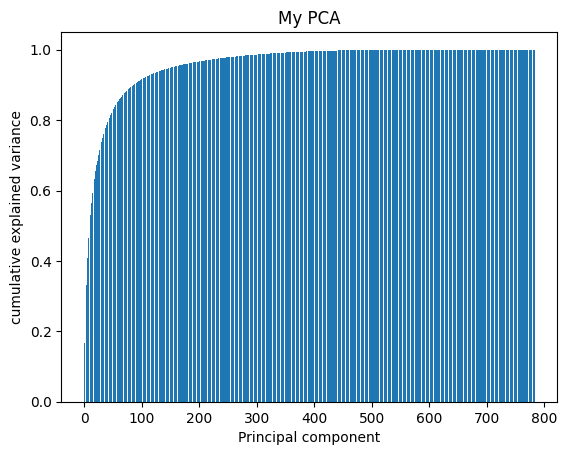

In [7]:
cumsum = np.cumsum(pca.eigenvalues)
plt.bar(np.arange(784), cumsum)
plt.ylabel('cumulative explained variance')
plt.xlabel('Principal component')
plt.title('My PCA')
feature_count = np.argmax(cumsum>=0.9)+1
print(feature_count)

As it is shown above 87 components are needed to cover 90% of the variance. So the number of components is set to 87.

In [8]:
pca.set_n_components(feature_count)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

### Autoencoder
&nbsp; The autoencoder class maps the input to a lower dimensional space and then maps it back to the original space. It takes one parameter which is the number of components. It consists of 3 layers. The first layer is the input layer which has 784 neurons. The second layer is the hidden layer which has the number of neurons equal to the number of components. The third layer is the output layer which has 784 neurons. The activation function of the hidden layer is relu and the activation function of the output layer is sigmoid.<br>
Refrence: https://www.tensorflow.org/tutorials/generative/autoencoder

In [9]:
# Ref: https://www.tensorflow.org/tutorials/generative/autoencoder
# It was mentiond that using ready-made libraries is allowed.

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  


In [10]:
# Ref: https://www.tensorflow.org/tutorials/generative/autoencoder
latent_dim = feature_count
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0209 - val_loss: 0.0073
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0055 - val_loss: 0.0041
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 5/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 8/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.002

The cell below shows the original images and the reconstructed images. First the encoder is used to map the images to the lower dimensional space which is used in the next cells to classify the images. Then the decoder is used to map the images back to the original space. The images are shown in the next cell.

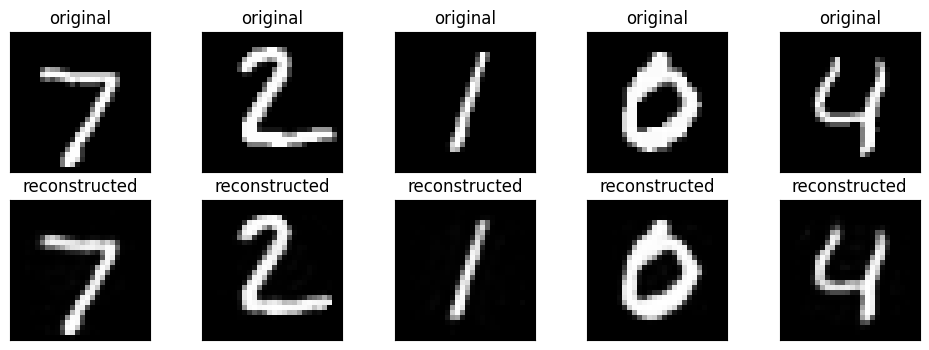

In [11]:
# Ref: https://www.tensorflow.org/tutorials/generative/autoencoder

encoded_imgs_test = autoencoder.encoder(x_test).numpy() #  we will use this in the future
encoded_imgs_train = autoencoder.encoder(x_train).numpy() # we will use this in the futue
decoded_imgs_test = autoencoder.decoder(encoded_imgs_test).numpy()
n = 5
plt.figure(figsize=(12, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i].reshape(28,28))
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs_test[i].reshape(28,28))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

### LDA
&nbsp; LDA is used to reduce the dimension of the dataset.

In [12]:
# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=9)
lda.fit(x_train, y_train)
x_train_lda = lda.transform(x_train)
x_test_lda = lda.transform(x_test)
print(x_train_lda.shape)

(60000, 9)


### Classification
&nbsp; In this part the dataset is classified using the XGBoost library.XGboost is a gradient boosted decision tree.The accuracy of the classification is calculated and the confusion matrix is drawn.<br>
Other algorithm were used such as svm from sklearn library which were very slow and it took 15 minutes to classify the dataset. With this library the model is trained within 1 minute and its accuracy is acceptable.

In [13]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

In [31]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob",tree_method = 'gpu_hist',max_depth = 7, verbosity = 1)
xgb_model.fit(encoded_imgs_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [32]:
y_pred_autoencoder_xgb = xgb_model.predict(encoded_imgs_test)
print('autoencoder accuracy: '+ str(accuracy_score(y_true = y_test , y_pred= y_pred_autoencoder_xgb)))

autoencoder accuracy: 0.9573


In [29]:
xgb_model_pca = xgb.XGBClassifier(objective="multi:softprob",tree_method = 'gpu_hist'  ,max_depth = 7,verbosity = 1)
xgb_model_pca.fit(x_train_pca, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [30]:
y_pred_pca_xgb = xgb_model_pca.predict(x_test_pca)
print('pca accuracy: '+ str(accuracy_score(y_true = y_test , y_pred= y_pred_pca_xgb)))

pca accuracy: 0.9667


In [26]:
xgb_model_lda = xgb.XGBClassifier(objective="multi:softprob" ,tree_method = 'gpu_hist' ,max_depth = 7,verbosity = 1)
xgb_model_lda.fit(x_train_lda, y_train)
y_pred_lda_xgb = xgb_model_lda.predict(x_test_lda)
accuracy_score(y_true = y_test , y_pred= y_pred_lda_xgb)


0.9167

In [20]:
xgb_model_none = xgb.XGBClassifier(objective="multi:softprob",tree_method = 'gpu_hist',max_depth = 7, verbosity = 1)
xgb_model_none.fit(x_train, y_train)
y_pred_none_xgb = xgb_model_none.predict(x_test)
accuracy_score(y_true = y_test , y_pred= y_pred_none_xgb)

0.978

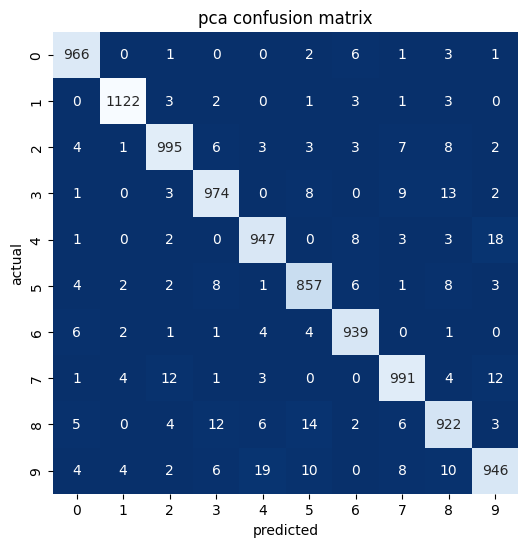

In [21]:
#plotting the confusion matrix
fig, ax = plt.subplots(figsize=(6,6))
cm = confusion_matrix(y_true=y_test,y_pred = y_pred_pca_xgb)
sns.heatmap(cm,annot=True, fmt='d', cmap='Blues_r', ax=ax, cbar=False)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('pca confusion matrix')
plt.show()

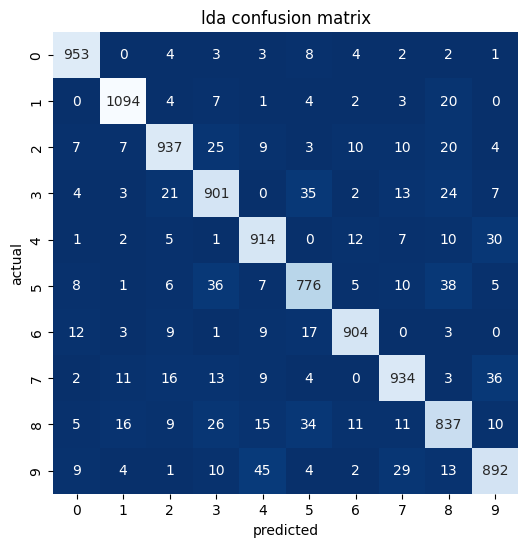

In [22]:
#plotting the confusion matrix
fig, ax = plt.subplots(figsize=(6,6))
cm = confusion_matrix(y_true=y_test,y_pred = y_pred_lda_xgb)
sns.heatmap(cm,annot=True, fmt='d', cmap='Blues_r', ax=ax, cbar=False)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('lda confusion matrix')
plt.show()

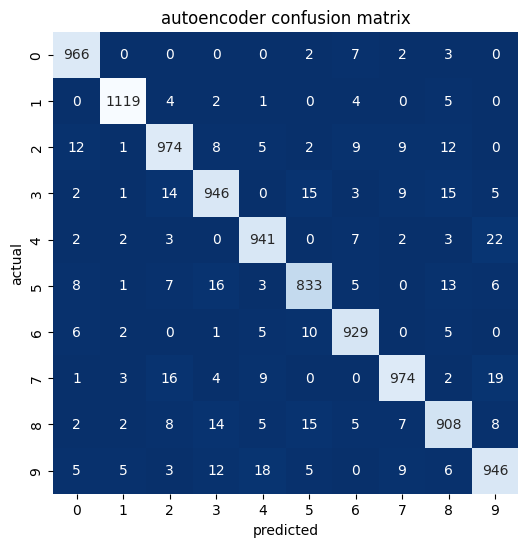

In [23]:
#plotting the confusion matrix
fig, ax = plt.subplots(figsize=(6,6))
cm = confusion_matrix(y_true=y_test,y_pred = y_pred_autoencoder_xgb)
sns.heatmap(cm,annot=True, fmt='d', cmap='Blues_r', ax=ax, cbar=False)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('autoencoder confusion matrix')
plt.show()

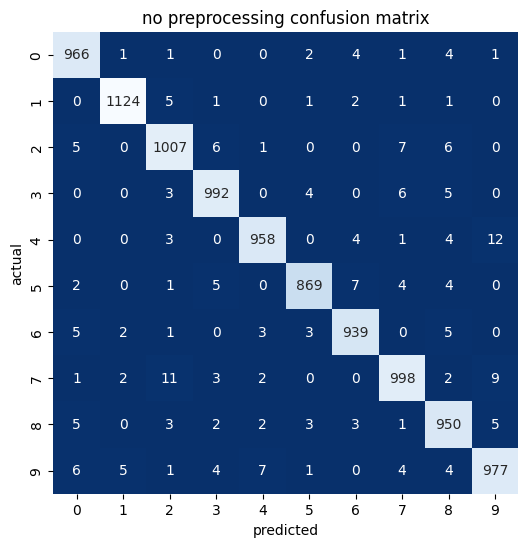

In [24]:
#plotting the confusion matrix
fig, ax = plt.subplots(figsize=(6,6))
cm = confusion_matrix(y_true=y_test,y_pred = y_pred_none_xgb)
sns.heatmap(cm,annot=True, fmt='d', cmap='Blues_r', ax=ax, cbar=False)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('no preprocessing confusion matrix')
plt.show()

### Conclusion
&nbsp; As it is shown above, the accuracy of the train set without feature reduction is 97.8%. The other models have lower accuracy. 96.7% (using pca) , 95.6 (%using autoencoder) and 91.7% (using LDA).
Although the accuracy is slightly lower, the time needed to train the model is much lower. So using feature reduction is a good idea when the dataset is large. This is the main reason that feature reduction is used in machine learning. It reduces the time needed to train the model and also reduces the memory needed to store the model.<br>
PCA algorithm is the best one to use in this case. It has the highest accuracy and also it is the fastest one. Its accuracy is . The autoencoder is the slowest one. It takes about 10 times more time to train the model. however in total it takes less time than **not** using feature reduction. The LDA algorithm is the worst one. It has the lowest accuracy and also it is the second slowest one. So it is not a good idea to use LDA in this case.<br>
If other algortihms are used which don't use gpu to be trained, the dataset which has 60000 images, will take a lot of time to be trained. For instance SVM from sklearn library takes more than 15 minutes to be trained on x_train_pca dataset and more than 40 minutes on the normal dataset. So using feature reduction is a good idea in this case.